In [6]:
import pandas as pd
import snscrape.modules.twitter as sntwitter
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import text2emotion as te
import emoji
from collections import Counter
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Karol\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Karol\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Karol\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
tweets = []

for i, tweet in enumerate(sntwitter.TwitterSearchScraper('#BlackLivesMatter since:2022-05-22 until:2023-05-22').get_items()):
    if i+1 > 5000:
        break
    tweets.append([tweet.id, tweet.date, tweet.user.username, tweet.rawContent, tweet.user.location, tweet.likeCount])

df = pd.DataFrame(tweets, columns=['id', 'date', 'username', 'content', 'location', 'likes'])
print(df.shape)

Unavailable user in card on tweet 1660392261723496448
User 14204245 not found in user refs in card on tweet 1660392261723496448
Unavailable user in card on tweet 1660377399660355587
User 14204245 not found in user refs in card on tweet 1660377399660355587
Unavailable user in card on tweet 1660071479109730305
User 14204245 not found in user refs in card on tweet 1660071479109730305
Unavailable user in card on tweet 1659809184890736641
User 1476608056267972609 not found in user refs in card on tweet 1659809184890736641
Could not translate t.co card URL on tweet 1659802556489670656
Unavailable user in card on tweet 1659722376018313221
User 14204245 not found in user refs in card on tweet 1659722376018313221
Unavailable user in card on tweet 1659716880028913665
User 14204245 not found in user refs in card on tweet 1659716880028913665


(5000, 6)


In [3]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Deleting links
    text = re.sub(r'http\S+|www.\S+', '', text, flags=re.MULTILINE)
    # Deleting hashtags and mentions
    text = re.sub(r'#\S+|@\S+', '', text)
    # # Deleting 
    # text = re.sub(r'\W', ' ', text)
    # Tokenizing and lemmatizing
    text = word_tokenize(text)
    text = [lemmatizer.lemmatize(word) for word in text if word not in stop_words]
    return text

df['processed_text'] = df['content'].apply(preprocess_text)

In [4]:
nltk.download('vader_lexicon')

def emotion_analysis(text):
    emotions = te.get_emotion(' '.join(text))
    return emotions

def sentiment_analysis(text):
    sid = SentimentIntensityAnalyzer()
    if isinstance(text, list):
        text = ' '.join(text)
    sentiment = sid.polarity_scores(text)
    return sentiment

df['sentiment'] = df['processed_text'].apply(sentiment_analysis)
df['emotions'] = df['processed_text'].apply(emotion_analysis)
df['sentiment'] = df['sentiment'].apply(lambda x: x['compound'])
df['emotions'] = df['emotions'].apply(lambda x: max(x, key=x.get))

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


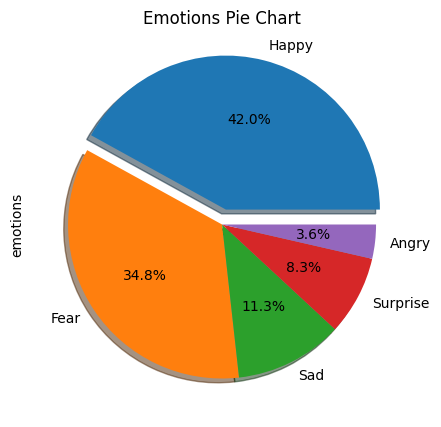

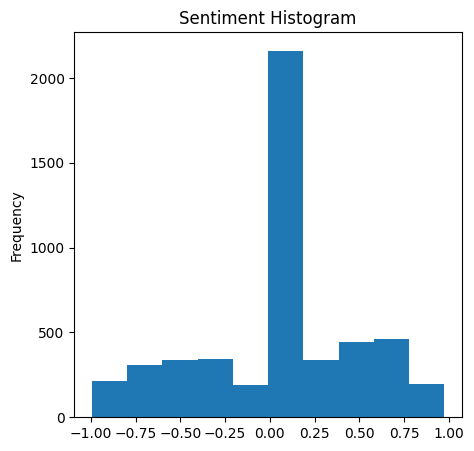

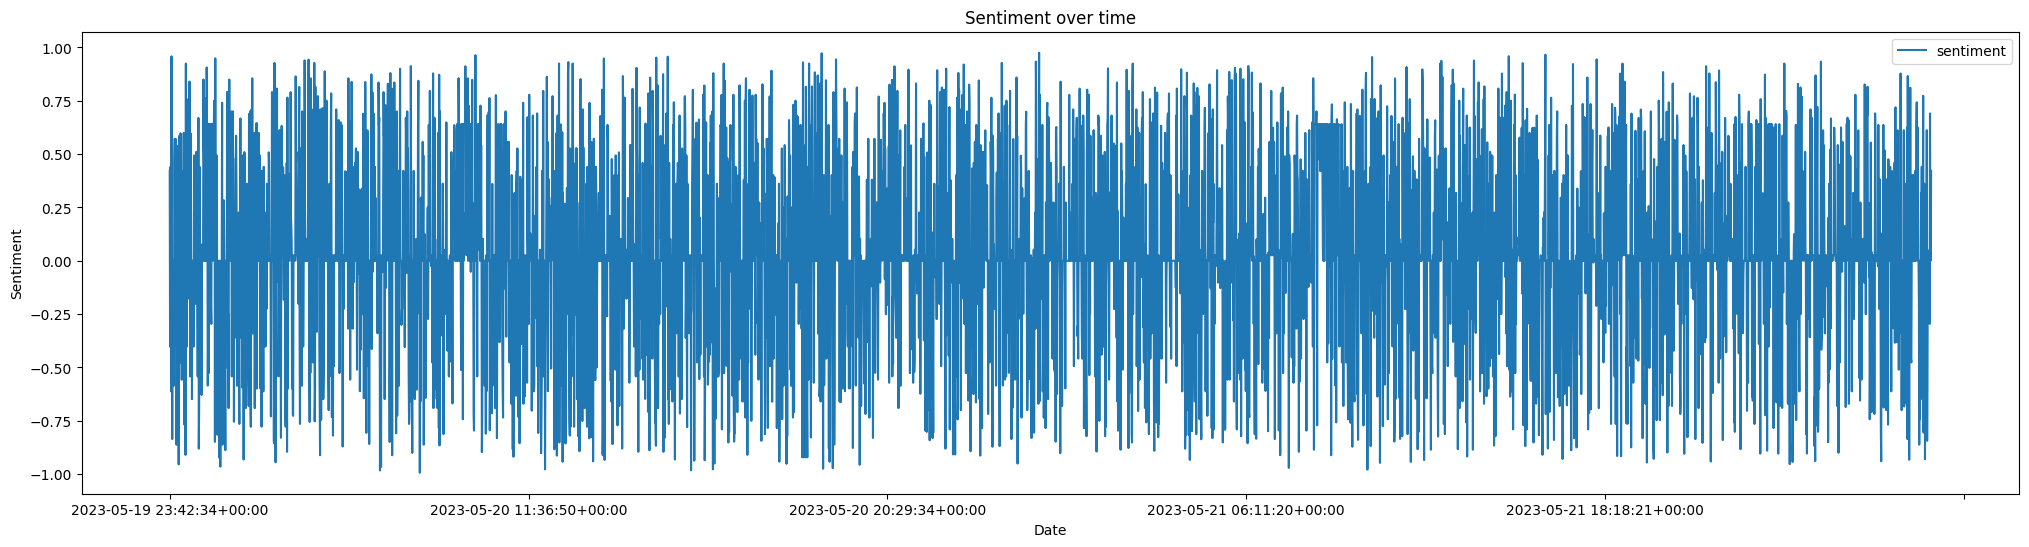

In [19]:
# df['date'] = pd.to_datetime(df['date'])
# df = df.sort_values(by='date')
# df.to_csv('tweets.csv', index=False)
df = pd.read_csv('tweets.csv')
df_agg = df.groupby('date')['sentiment'].mean().reset_index()

# Pie chart for 'emotions'
plt.figure(figsize=(5,5))
df['emotions'].value_counts().plot(kind='pie', autopct='%1.1f%%', explode=[0.1, 0, 0, 0, 0], shadow=True)
plt.title('Emotions Pie Chart')
plt.show() 

# Histogram for 'sentiment'
plt.figure(figsize=(5,5))
df['sentiment'].plot(kind='hist')
plt.title('Sentiment Histogram')
plt.show()

# Line plot for 'sentiment' over time
fig, ax = plt.subplots(figsize=(25, 6))
df_agg.plot(kind='line', x='date', y='sentiment', ax=ax)
plt.xlabel('Date')
plt.ylabel('Sentiment')
plt.title('Sentiment over time')
plt.show()


In [6]:
# Wyniki dla sentymentu
sentiment_results = df['sentiment'].apply(pd.Series)
print(sentiment_results.describe())

# Wyniki dla emocji
emotion_results = df['emotions'].apply(pd.Series)
print(emotion_results.describe())

                 0
count  5000.000000
mean      0.023862
std       0.430790
min      -0.993700
25%      -0.170975
50%       0.000000
75%       0.318200
max       0.975300
            0
count    5000
unique      5
top     Happy
freq     2099


In [7]:
df = pd.read_csv('tweets.csv')
df.shape

(5000, 9)

In [8]:
# df = df[~df['content'].str.contains('@@@@@@@@')]
# df = df[~df['content'].str.contains('http://')]
# df = df[~df['content'].str.contains('https://')]
# df = df.dropna()
# df.shape